# Food Classification MLOps Pipeline

This notebook demonstrates an end-to-end machine learning pipeline for food image classification.

## Dataset Overview
- **Classes**: Bread, Dairy product, Dessert, Egg, Fried food, Meat, Noodles-Pasta, Rice, Seafood, Soup, Vegetable-Fruit
- **Task**: Multi-class image classification
- **Model**: Convolutional Neural Network with Transfer Learning

## 1. Import Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import cv2
from PIL import Image
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


In [2]:
# Quick environment test
import sys
print(f"Python version: {sys.version}")
print("Environment is working!")

Python version: 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
Environment is working!


## 2. Data Acquisition and Exploration

In [3]:
# Define data paths
DATA_DIR = '../data'
MODEL_DIR = '../models'
SRC_DIR = '../src'

# Create directories if they don't exist
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(SRC_DIR, exist_ok=True)

# Get class names
classes = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
classes.sort()
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")

# Create class to index mapping
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

print(f"\nClass to index mapping:")
for cls, idx in class_to_idx.items():
    print(f"{cls}: {idx}")

Number of classes: 11
Classes: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']

Class to index mapping:
Bread: 0
Dairy product: 1
Dessert: 2
Egg: 3
Fried food: 4
Meat: 5
Noodles-Pasta: 6
Rice: 7
Seafood: 8
Soup: 9
Vegetable-Fruit: 10


Total images: 3347

Images per class:
Bread: 368
Dairy product: 148
Dessert: 500
Egg: 335
Fried food: 287
Meat: 432
Noodles-Pasta: 147
Rice: 96
Seafood: 303
Soup: 500
Vegetable-Fruit: 231


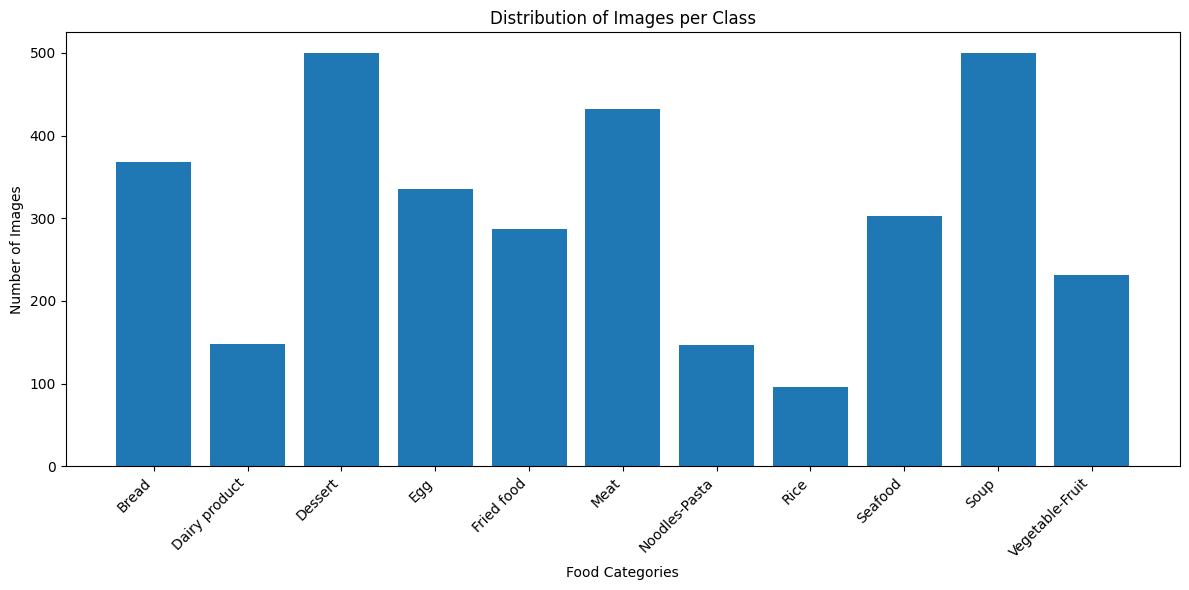


Class imbalance ratio: 5.21 (max/min)


In [4]:
# Analyze dataset distribution
class_counts = {}
total_images = 0

for class_name in classes:
    class_path = os.path.join(DATA_DIR, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[class_name] = len(image_files)
    total_images += len(image_files)

print(f"Total images: {total_images}")
print(f"\nImages per class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

# Create visualization of class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Distribution of Images per Class')
plt.xlabel('Food Categories')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Check for class imbalance
min_count = min(class_counts.values())
max_count = max(class_counts.values())
imbalance_ratio = max_count / min_count
print(f"\nClass imbalance ratio: {imbalance_ratio:.2f} (max/min)")

## 3. Data Preprocessing and Augmentation

In [5]:
# Define image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

def load_and_preprocess_data(data_dir, img_size, validation_split=0.2):
    """
    Load and preprocess image data
    """
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=validation_split
    )
    
    # Only rescaling for validation data
    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split
    )
    
    # Create data generators
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=42
    )
    
    validation_generator = val_datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        seed=42
    )
    
    return train_generator, validation_generator

# Load data
train_gen, val_gen = load_and_preprocess_data(DATA_DIR, IMG_SIZE, VALIDATION_SPLIT)

print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")
print(f"Number of classes: {train_gen.num_classes}")
print(f"Class indices: {train_gen.class_indices}")

Found 2681 images belonging to 11 classes.
Found 666 images belonging to 11 classes.
Training samples: 2681
Validation samples: 666
Number of classes: 11
Class indices: {'Bread': 0, 'Dairy product': 1, 'Dessert': 2, 'Egg': 3, 'Fried food': 4, 'Meat': 5, 'Noodles-Pasta': 6, 'Rice': 7, 'Seafood': 8, 'Soup': 9, 'Vegetable-Fruit': 10}
Found 666 images belonging to 11 classes.
Training samples: 2681
Validation samples: 666
Number of classes: 11
Class indices: {'Bread': 0, 'Dairy product': 1, 'Dessert': 2, 'Egg': 3, 'Fried food': 4, 'Meat': 5, 'Noodles-Pasta': 6, 'Rice': 7, 'Seafood': 8, 'Soup': 9, 'Vegetable-Fruit': 10}


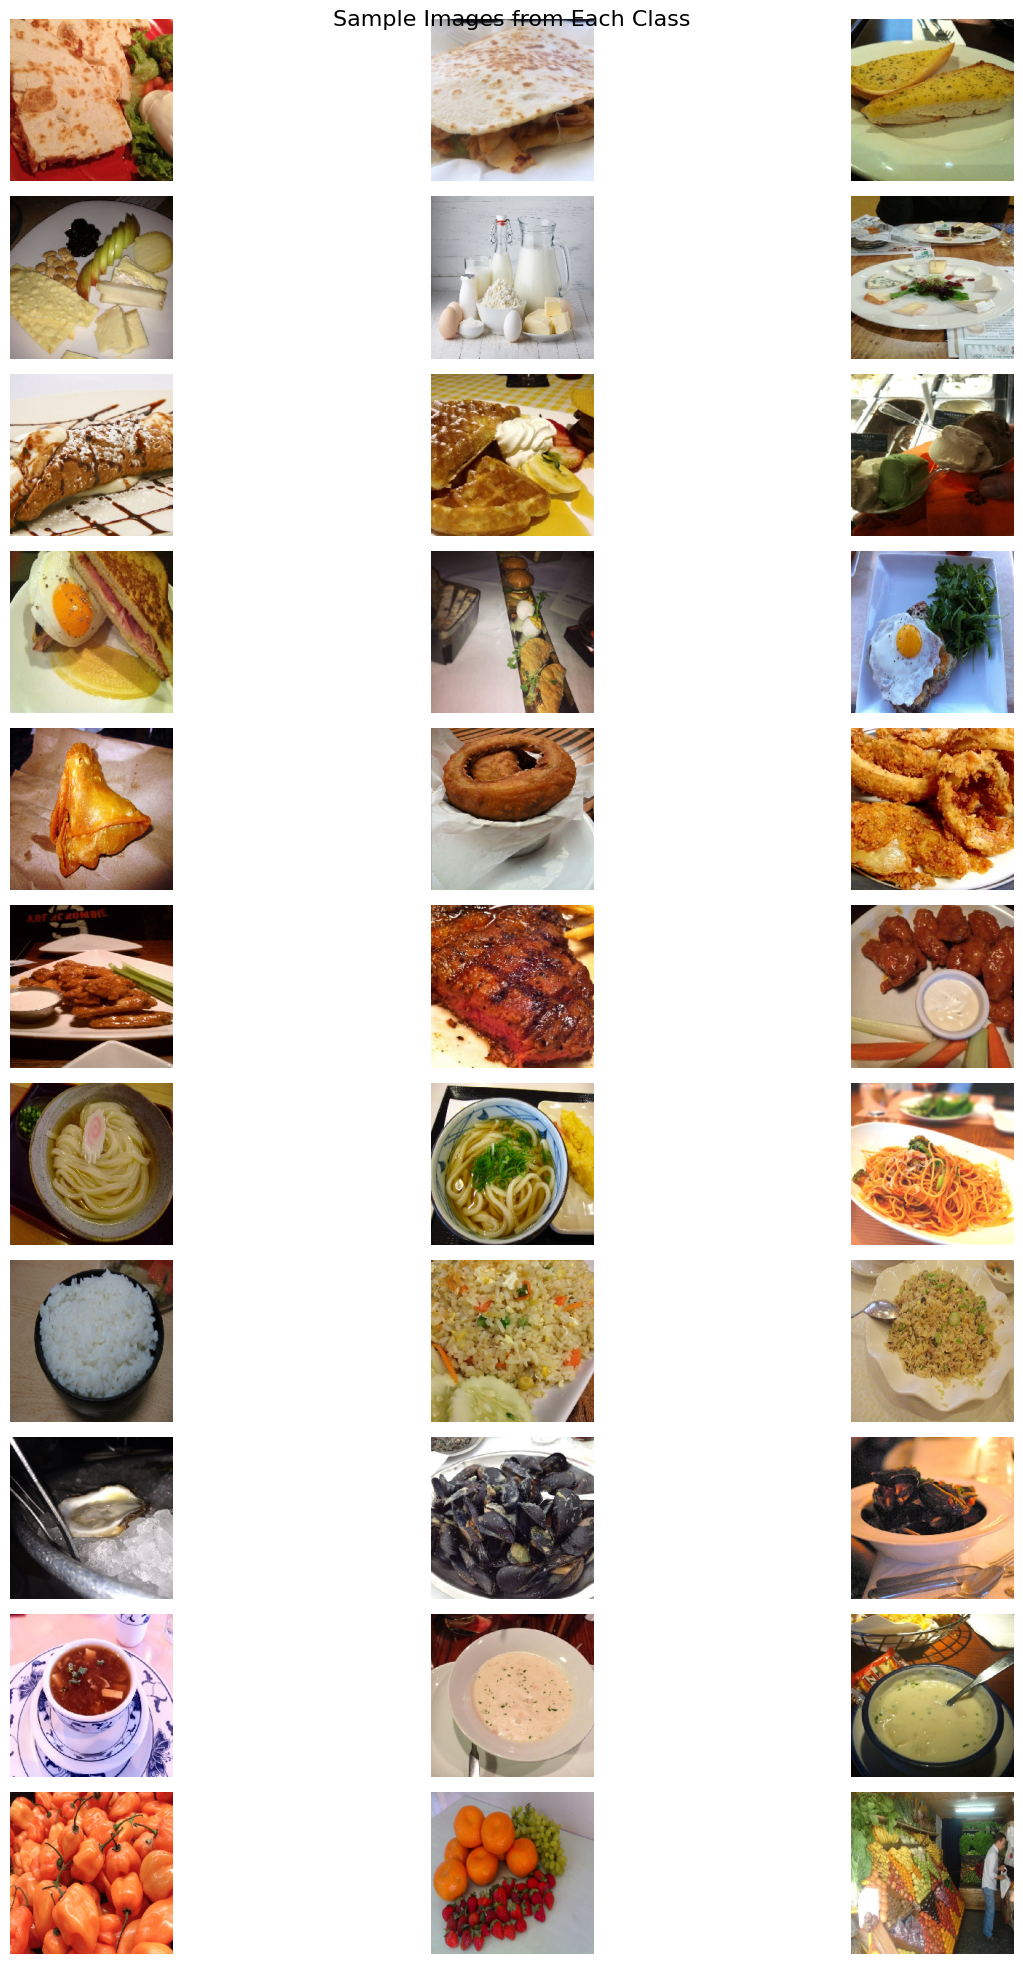

In [6]:
# Visualize sample images from each class
def visualize_samples(data_dir, classes, num_samples=3):
    """
    Visualize sample images from each class
    """
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 20))
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for j in range(min(num_samples, len(image_files))):
            img_path = os.path.join(class_path, image_files[j])
            img = load_img(img_path, target_size=IMG_SIZE)
            
            if len(classes) == 1:
                axes[j].imshow(img)
                axes[j].set_title(f"{class_name}")
                axes[j].axis('off')
            else:
                axes[i, j].imshow(img)
                if j == 0:
                    axes[i, j].set_ylabel(class_name, fontsize=12)
                axes[i, j].axis('off')
    
    plt.suptitle('Sample Images from Each Class', fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_samples(DATA_DIR, classes, num_samples=3)

## 4. Model Creation with Transfer Learning

In [7]:
def create_model(num_classes, input_shape=(224, 224, 3), base_model_name='MobileNetV2'):
    """
    Create a CNN model with transfer learning
    """
    # Load pre-trained base model
    if base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add custom classification head
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
model = create_model(num_classes=len(classes), base_model_name='MobileNetV2')

# Compile model with optimization techniques
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,055,179 (11.65 MB)

 Trainable params: 793,611 (3.03 MB)

 Non-trainable params: 2,261,568 (8.63 MB)

In [8]:
# Define callbacks for optimization
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, 'best_food_classifier.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Model compilation completed. Ready for training.")

Model compilation completed. Ready for training.


## 5. Model Training

In [9]:
# Train the model
EPOCHS = 50

print("Starting model training...")
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Starting model training...
Epoch 1/50
Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3947 - loss: 2.0116 - precision: 0.5427 - recall: 0.2836
Epoch 1: val_accuracy improved from None to 0.73423, saving model to ../models\best_food_classifier.h5

Epoch 1: val_accuracy improved from None to 0.73423, saving model to ../models\best_food_classifier.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.5241 - loss: 1.5113 - precision: 0.6653 - recall: 0.4248 - val_accuracy: 0.7342 - val_loss: 0.8024 - val_precision: 0.8551 - val_recall: 0.6201 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
19/84 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - accuracy: 0.6525 - loss: 1.1260 - precision: 0.7229 - recall: 0.5758

KeyboardInterrupt: 

In [ ]:
# Plot training history
def plot_training_history(history):
    """
    Plot training and validation metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Training Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

## 6. Model Evaluation

In [ ]:
# Load the best model
best_model = tf.keras.models.load_model(os.path.join(MODEL_DIR, 'best_food_classifier.h5'))

# Make predictions on validation data
val_gen.reset()
predictions = best_model.predict(val_gen, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = val_gen.classes

# Calculate metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print("=== Model Evaluation Metrics ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Detailed classification report
print("\n=== Detailed Classification Report ===")
class_names = list(val_gen.class_indices.keys())
print(classification_report(true_classes, predicted_classes, target_names=class_names))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\n=== Per-Class Accuracy ===")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {per_class_accuracy[i]:.4f}")

## 7. Model Interpretability and Feature Analysis

In [ ]:
# Analyze model predictions on sample images
def analyze_predictions(model, data_dir, classes, num_samples=5):
    """
    Analyze model predictions with confidence scores
    """
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(20, 25))
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for j in range(min(num_samples, len(image_files))):
            img_path = os.path.join(class_path, image_files[j])
            
            # Load and preprocess image
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # Make prediction
            prediction = model.predict(img_array, verbose=0)
            predicted_class_idx = np.argmax(prediction)
            confidence = np.max(prediction)
            predicted_class = classes[predicted_class_idx]
            
            # Determine if prediction is correct
            is_correct = predicted_class == class_name
            color = 'green' if is_correct else 'red'
            
            # Plot image with prediction
            if len(classes) == 1:
                axes[j].imshow(img)
                axes[j].set_title(f"True: {class_name}\nPred: {predicted_class}\nConf: {confidence:.3f}", 
                                color=color)
                axes[j].axis('off')
            else:
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"True: {class_name}\nPred: {predicted_class}\nConf: {confidence:.3f}", 
                                    color=color, fontsize=8)
                axes[i, j].axis('off')
                if j == 0:
                    axes[i, j].set_ylabel(class_name, fontsize=10)
    
    plt.suptitle('Model Predictions Analysis (Green=Correct, Red=Incorrect)', fontsize=16)
    plt.tight_layout()
    plt.show()

analyze_predictions(best_model, DATA_DIR, classes, num_samples=3)

In [ ]:
# Confidence distribution analysis
all_predictions = []
all_confidences = []
all_true_labels = []

for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(DATA_DIR, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for img_file in image_files[:50]:  # Sample 50 images per class
        img_path = os.path.join(class_path, img_file)
        
        # Load and preprocess image
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Make prediction
        prediction = best_model.predict(img_array, verbose=0)
        confidence = np.max(prediction)
        predicted_class_idx = np.argmax(prediction)
        
        all_predictions.append(predicted_class_idx)
        all_confidences.append(confidence)
        all_true_labels.append(class_idx)

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_confidences = np.array(all_confidences)
all_true_labels = np.array(all_true_labels)

# Plot confidence distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(all_confidences, bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribution of Prediction Confidences')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
correct_predictions = all_predictions == all_true_labels
correct_confidences = all_confidences[correct_predictions]
incorrect_confidences = all_confidences[~correct_predictions]

plt.hist(correct_confidences, bins=20, alpha=0.7, label='Correct', color='green')
plt.hist(incorrect_confidences, bins=20, alpha=0.7, label='Incorrect', color='red')
plt.title('Confidence: Correct vs Incorrect Predictions')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 3, 3)
class_accuracies = []
for i in range(len(classes)):
    class_mask = all_true_labels == i
    class_accuracy = np.mean(all_predictions[class_mask] == all_true_labels[class_mask])
    class_accuracies.append(class_accuracy)

plt.bar(range(len(classes)), class_accuracies)
plt.title('Per-Class Accuracy')
plt.xlabel('Class Index')
plt.ylabel('Accuracy')
plt.xticks(range(len(classes)), [f'{i}\n{classes[i][:8]}' for i in range(len(classes))], rotation=45)

plt.tight_layout()
plt.show()

print(f"\nOverall accuracy on sample: {np.mean(all_predictions == all_true_labels):.4f}")
print(f"Average confidence: {np.mean(all_confidences):.4f}")
print(f"Average confidence for correct predictions: {np.mean(correct_confidences):.4f}")
print(f"Average confidence for incorrect predictions: {np.mean(incorrect_confidences):.4f}")

## 8. Save Model and Metadata

In [ ]:
# Save the final model
final_model_path = os.path.join(MODEL_DIR, 'food_classifier_final.h5')
best_model.save(final_model_path)

# Save model metadata
metadata = {
    'model_name': 'Food Classification CNN',
    'created_date': datetime.now().isoformat(),
    'classes': classes,
    'class_to_idx': class_to_idx,
    'idx_to_class': idx_to_class,
    'num_classes': len(classes),
    'input_shape': IMG_SIZE + (3,),
    'metrics': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1)
    },
    'training_params': {
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'validation_split': VALIDATION_SPLIT,
        'base_model': 'MobileNetV2'
    }
}

metadata_path = os.path.join(MODEL_DIR, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

# Save class mappings separately for easy access
joblib.dump(class_to_idx, os.path.join(MODEL_DIR, 'class_to_idx.pkl'))
joblib.dump(idx_to_class, os.path.join(MODEL_DIR, 'idx_to_class.pkl'))

print(f"Model saved to: {final_model_path}")
print(f"Metadata saved to: {metadata_path}")
print(f"Class mappings saved to: {MODEL_DIR}")

print("\n=== Training Complete ===")
print(f"Final Model Performance:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall: {recall:.4f}")
print(f"  - F1-Score: {f1:.4f}")